### This is the same notebook as analyze_sql_data.ipynb but includes multiple years

In [174]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from copy import deepcopy

from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
                            accuracy_score, 
                            precision_score, 
                            recall_score, 
                            f1_score, 
                            roc_curve, 
                            roc_auc_score, 
                            confusion_matrix
                            )
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import confusion_matrix

from unbalanced_dataset import OverSampler, SMOTE

import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

In [175]:
CONFIG = {}

with open('config.txt', "r") as in_file:
    for line in in_file:
        line = line.split(":")
        parameter = line[0].strip()
        value = line[1].strip()
        CONFIG[parameter] = value
                
engine_path = 'postgresql://'+CONFIG['username']+':'+\
                CONFIG['password']+'@'+CONFIG['ip']+\
                ':'+CONFIG['port']+'/'+CONFIG['database']
        
engine = create_engine(engine_path)

### Want something like:

    SELECT
        table4.countrycode as 'countrycode',
        b.table1 as 'table1',
        b.table2 as 'table2',
        b.table3 as 'table3',
        table4.year as 'table4'
        (SELECT
            table3.countrycode as 'countrycode',
            a.table1 as 'table1',
            a.table2 as 'table2',
            table3.year as 'table3'
         FROM
            (SELECT
                 table1.countrycode as 'countrycode',
                 table1.year as 'table1',
                 table2.year as 'table2'
             FROM
                 table1
             JOIN
                 table2
               ON 
                 table1.countrycode = table2.countrycode
             ) a
         JOIN
             table3
           ON
             a.countrycode = table3.countrycode  
        ) b    
    JOIN
        table4
      ON
        a.countrycode = table3.countrycode 
    
        
       


In [176]:
def makeSQLQuery(table_names, year):
    dotyyear = '.y' + str(year)
    current_unit = 'a'
    query = '(SELECT ' + table_names[0] + '.countrycode AS countrycode, ' + \
            table_names[0] + dotyyear + ' AS ' + table_names[0] + ', ' + \
            table_names[1] + dotyyear + ' AS ' + table_names[1] + \
            ' FROM ' + table_names[0] + \
            ' JOIN ' + table_names[1] + \
            ' ON ' + table_names[0] + '.countrycode=' + table_names[1] + '.countrycode) '
    query = query + current_unit
    
    for table in table_names[2:]:
        curr_index = table_names.index(table)
        temp_list = table_names[:curr_index+1]
        
        pre_string = '(SELECT ' + table + '.countrycode as countrycode'
        
        for temp_table in temp_list[:-1]:
            pre_string = pre_string + ', ' + current_unit + '.' + temp_table + ' AS ' + temp_table
        
        pre_string = pre_string + ', ' + table + dotyyear + ' AS ' + table
        
        query = pre_string + ' FROM ' + query + ' JOIN ' + table + \
                ' ON ' + current_unit + '.countrycode=' + table + '.countrycode) '
        
        current_unit = current_unit + 'a'
        query = query + current_unit
        
    query = query.rsplit(' ', 1)[0][1:-1]
    
    return query
    
    

## Change these to select data

In [177]:
table_names = ['civil_liberties', \
               'political_rights', \
               #'freedom_status', \
               #'corruption_perception', \
               'female_legislators', \
               'population_growth', \
               'population_female', \
               #'under_5_mortality', \
               'life_expectancy', \
               #'population_0_14', \
               'population_15_64',  \
               #'population_65_up', \
               #'terror_new', \
               #'peace_new', \
               #'refugees_percapita', \
               'zscores']

In [178]:
x_cols = table_names[:-1]

In [179]:
years = [2008, 2009, 2010, 2011, 2012, 2013]

In [180]:
full_data = pd.DataFrame()

In [181]:
for year in years:
    query = makeSQLQuery(table_names, year)
    year_data = pd.read_sql_query(query, engine)
    year_data['year'] = year
    year_data = year_data.set_index(['year', 'countrycode'])
    full_data = pd.concat([full_data, year_data])
    


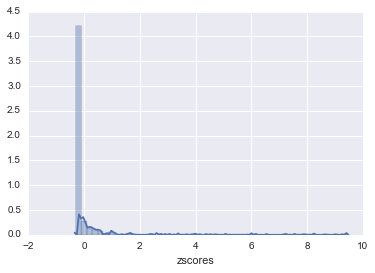

In [182]:
sns.distplot(full_data.dropna()['zscores'].astype(float))

(array([ 989.,   22.,    7.,    7.,    7.,    2.,    3.,    3.,    5.,    4.]),
 array([-0.29313644,  0.67991785,  1.65297214,  2.62602643,  3.59908072,
         4.57213501,  5.5451893 ,  6.51824359,  7.49129788,  8.46435217,
         9.43740646]),
 <a list of 10 Patch objects>)

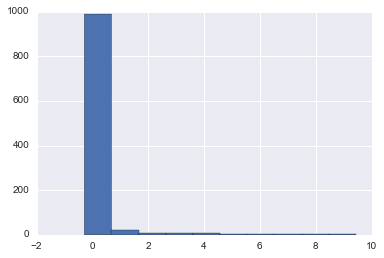

In [183]:
import pylab as pl

pl.hist(sorted(list(full_data.dropna()['zscores'].astype(float))))



In [184]:
full_data.head()

civil_liberties  political_rights  female_legislators  \
year countrycode                                                          
2008 AFG                        6                 5                27.7   
     AGO                        5                 6                37.3   
     ALB                        3                 3                 7.1   
     ARE                        5                 6                22.5   
     ARG                        2                 2                40.0   

                  population_growth  population_female  life_expectancy  \
year countrycode                                                          
2008 AFG                   2.485315          48.512909        58.225024   
     AGO                   3.374180          50.493712        49.847390   
     ALB                  -0.767343          49.610212        76.632317   
     ARE                  13.810060          25.880062        76.307756   
     ARG                   1.025393          51.087196        75.166268   

                  population_15_64       zscores  
year countrycode                                  
2008 AFG                 49.946087   6.546331355  
     AGO                 49.356104   0.281696206  
     ALB                 66.816430   0.055357722  
     ARE                 84.600650  -0.267222176  
     ARG                 63.456290   -0.26793528

In [185]:
full_data['zscores'] = full_data['zscores'].astype(float)

full_data.loc[full_data['zscores'] > 0, 'zscores'] = 1
full_data.loc[full_data['zscores'] <= 0, 'zscores'] = 0

try:
    full_data.loc[full_data['freedom_status'] == 'F', 'freedom_status'] = -1
    full_data.loc[full_data['freedom_status'] == 'PF', 'freedom_status'] = 0
    full_data.loc[full_data['freedom_status'] == 'NF', 'freedom_status'] = 1
except:
    pass


In [186]:
#The rows to be dropped
full_data[full_data.isnull().any(axis=1)]

civil_liberties  political_rights  female_legislators  \
year countrycode                                                          
2008 FJI                        4                 6                 NaN   
     GIN                        5                 7                 NaN   
     LUX                        1                 1                23.3   
     MMR                        7                 7                 NaN   
     SSD                      NaN               NaN                 NaN   
     TKM                        7                 7                 NaN   
     VUT                        2                 2                 3.8   
2009 FJI                        4                 6                 NaN   
     GIN                        6                 7                 NaN   
     LUX                        1                 1                20.0   
     MDG                        4                 6                 NaN   
     MMR                        7                 7                 NaN   
     SSD                      NaN               NaN                 NaN   
     VUT                        2                 2                 3.8   
     WSM                        2                 2                 8.2   
2010 FJI                        4                 6                 NaN   
     GIN                        5                 5                 NaN   
     LUX                        1                 1                20.0   
     NER                        4                 5                 NaN   
     SSD                      NaN               NaN                 NaN   
     TZA                        3                 3                 NaN   
2011 FJI                        4                 6                 NaN   
     GIN                        5                 5                 NaN   
     HRV                        2                 1                23.8   
     LBY                        6                 7                 NaN   
     LUX                        1                 1                25.0   
     ZAR                        6                 6                 NaN   
2012 FJI                        4                 6                 NaN   
     GHA                        2                 1                 NaN   
     GIN                        5                 5                 NaN   
     LKA                        4                 5                 5.8   
     LUX                        1                 1                21.7   
2013 ARG                        2                 2                 NaN   
     CAF                        7                 7                 NaN   
     EGY                        5                 6                 NaN   
     FJI                        4                 6                 NaN   
     GIN                        5                 5                 NaN   

                  population_growth  population_female  life_expectancy  \
year countrycode                                                          
2008 FJI                   1.010417          48.947707        69.022024   
     GIN                   2.671069          49.966108        54.777585   
     LUX                   1.787497          50.493425        80.539024   
     MMR                   0.651129          51.176312        64.367610   
     SSD                   4.362664          50.051550        52.593317   
     TKM                   1.213341          50.724437        64.756073   
     VUT                   2.416066          49.142388        70.254756   
2009 FJI                   1.020386          48.947824        69.202854   
     GIN                   2.728375          49.955495        55.556146   
     LUX                   1.851775          50.416014        80.636585   
     MDG                   2.814994          50.195519        62.918171   
     MMR                   0.663518          51.184720        64.643561   
     SSD                   4.403674       

In [187]:
full_data = full_data.dropna()

In [188]:
#Get Z scores of rows
#for col in x_cols:
#    full_data[col] = full_data[col].astype(float)
#    full_data[col] = (full_data[col] - full_data[col].mean())/full_data[col].std(ddof=0)


#### Get the score values WITHOUT cross validating 

In [189]:
def getScoreValues(X_train, 
                   X_test, 
                   y_train, 
                   y_test, 
                   model=KNeighborsClassifier(n_neighbors=6), 
                   verbose=True, 
                   get_features=True,
                   get_prediction=False
                  ):
    y_test_index=y_test.index
    
    model = model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy_score_value = accuracy_score(y_test, y_pred)
    precision_score_value = precision_score(y_test, y_pred)
    recall_score_value = recall_score(y_test, y_pred)
    f1_score_value = f1_score(y_test, y_pred)  
    roc_auc_value = roc_auc_score(y_test,y_pred)
    
    feature_importances = None
    if get_features:
        try:
            feature_importances = model.feature_importances_
            #print(feature_importances)
        except AttributeError:
            pass
    
    if verbose:
        #print(pd.concat([y_test,pd.Series(y_pred, index=y_test.index)], axis = 1))
        print('Accuracy: {}\nPrecision: {}\nRecall: {}\nf1: {}\nROC AUC: ()'.format(accuracy_score_value, \
                                                                       precision_score_value, \
                                                                       recall_score_value, \
                                                                       f1_score_value, \
                                                                       roc_auc_value))
    elif get_prediction:
        y_pred=pd.Series(y_pred, index=y_test_index)
        return y_pred
        
    else:
        return accuracy_score_value, \
               precision_score_value, \
               recall_score_value, \
               f1_score_value, \
               roc_auc_value, \
               feature_importances

In [190]:
X = full_data[x_cols]
y = full_data['zscores']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=4444)

In [191]:
getScoreValues(X_train, X_test, y_train, y_test, DecisionTreeClassifier())

Accuracy: 0.8984126984126984
Precision: 0.6274509803921569
Recall: 0.7111111111111111
f1: 0.6666666666666666
ROC AUC: ()


In [192]:
getScoreValues(X_train, X_test, y_train, y_test, BernoulliNB())

Accuracy: 0.8571428571428571
Precision: 0.0
Recall: 0.0
f1: 0.0
ROC AUC: ()


/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [193]:
getScoreValues(X_train, X_test, y_train, y_test, GaussianNB())

Accuracy: 0.7492063492063492
Precision: 0.3111111111111111
Recall: 0.6222222222222222
f1: 0.4148148148148148
ROC AUC: ()


In [194]:
getScoreValues(X_train, X_test, y_train, y_test, model=SVC())

Accuracy: 0.9238095238095239
Precision: 0.8
Recall: 0.6222222222222222
f1: 0.7000000000000001
ROC AUC: ()


In [195]:
getScoreValues(X_train, X_test, y_train, y_test, model=RandomForestClassifier())

Accuracy: 0.9333333333333333
Precision: 0.8529411764705882
Recall: 0.6444444444444445
f1: 0.7341772151898734
ROC AUC: ()


#### Print the ROC curve for a model

In [196]:
def getROCcurve(X_train, X_test, y_train, y_test, model=KNeighborsClassifier(n_neighbors=6)):
    model = model
    model.fit(X_train, y_train)
    y_scores = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)

    auc = roc_auc_score(y_test, y_scores)
    print('AUC: {}'.format(auc))
    
    fig,ax = plt.subplots()
    ax.plot(fpr, tpr, label='ROC Curve')

    fig.set_size_inches(12, 8, forward=True)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.legend(loc='best')

AUC: 0.9574485596707819


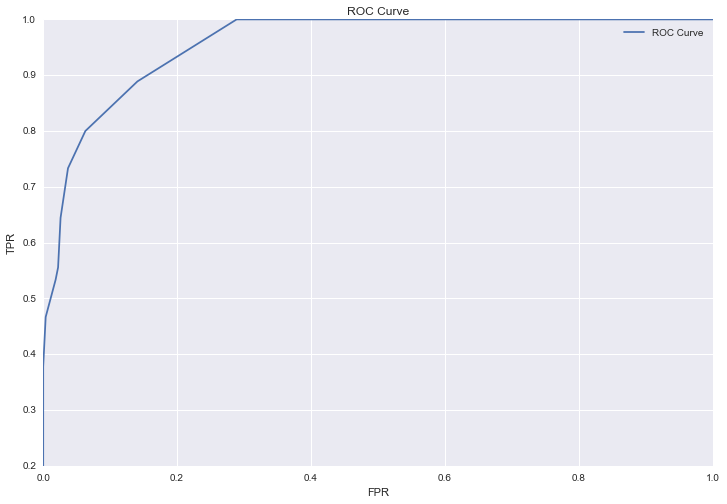

In [197]:
getROCcurve(X_train, X_test, y_train, y_test, model=RandomForestClassifier())

#### Cross Validate and Return Scores 

In [198]:
def getScoreValuesByCV(X, y, model=KNeighborsClassifier(n_neighbors=1)):
    
    accuracy_score_value = np.mean(cross_val_score(model, X, y, scoring='accuracy', cv=5))
    precision_score_value = np.mean(cross_val_score(model, X, y, scoring='precision', cv=5))
    recall_score_value = np.mean(cross_val_score(model, X, y, scoring='recall', cv=5))
    f1_score_value = np.mean(cross_val_score(model, X, y, scoring='f1', cv=5))
    roc_auc_value = np.mean(cross_val_score(model, X, y, scoring='roc_auc', cv=5))
    #roc_auc_value = 0  
        
    print('Accuracy: {}\nPrecision: {}\nRecall: {}\nf1: {}\nROC AUC: {}'.format(accuracy_score_value, \
                                                                   precision_score_value, \
                                                                   recall_score_value, \
                                                                   f1_score_value,
                                                                   roc_auc_value))

In [199]:
getScoreValuesByCV(X,y)

Accuracy: 0.9647202884419148
Precision: 0.8726392961876833
Recall: 0.897983870967742
f1: 0.8842950890033432
ROC AUC: 0.9372192909543374


In [200]:
getScoreValuesByCV(X,y, model=RandomForestClassifier())

Accuracy: 0.9437311503662216
Precision: 0.8855571847507331
Recall: 0.7766129032258065
f1: 0.8092550874023697
ROC AUC: 0.9743678509742619


In [201]:
getScoreValuesByCV(X,y, model=GaussianNB())

Accuracy: 0.7207147554366313
Precision: 0.28659782556715907
Recall: 0.5798387096774194
f1: 0.38337993592387665
ROC AUC: 0.7184708855325689


In [202]:
getScoreValuesByCV(X,y, model=DecisionTreeClassifier())

Accuracy: 0.9380167350733577
Precision: 0.8072237892190618
Recall: 0.7764112903225807
f1: 0.7835335588675568
ROC AUC: 0.863829859262019


In [203]:
getScoreValuesByCV(X,y, model=LogisticRegression())

Accuracy: 0.8656069298623551
Precision: 1.0
Recall: 0.10221774193548387
f1: 0.18270944741532977
ROC AUC: 0.7413749010349067


## Modeling with Over Sampling of Training Set

In [204]:
def oversample_data(X_t, y_t, ratio):
    x_columns = X_t.columns
    
    X_t = X_t.reset_index(drop=True).as_matrix()
    y_t = y_t.reset_index(drop=True).as_matrix()

    smote = OverSampler(ratio=ratio, verbose=False)
    smox, smoy = smote.fit_transform(X_t, y_t)
    X_t = pd.DataFrame(smox, columns=x_columns)
    y_t = pd.Series(smoy)
    return X_t, y_t


In [205]:
X = full_data[x_cols]
y = full_data['zscores']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=4444)

In [206]:
verbose = False
ratio = float(y.value_counts()[0]) / float(y.value_counts()[1])

X_train, y_train = oversample_data(X_train, y_train, ratio)

In [207]:
getScoreValues(X_train, X_test, y_train, y_test)

Accuracy: 0.8857142857142857
Precision: 0.5616438356164384
Recall: 0.9111111111111111
f1: 0.6949152542372882
ROC AUC: ()


In [208]:
getScoreValues(X_train, X_test, y_train, y_test, model=RandomForestClassifier())

Accuracy: 0.9333333333333333
Precision: 0.7727272727272727
Recall: 0.7555555555555555
f1: 0.7640449438202247
ROC AUC: ()


In [209]:
getScoreValues(X_train, X_test, y_train, y_test, model=BernoulliNB())

Accuracy: 0.7873015873015873
Precision: 0.21052631578947367
Recall: 0.17777777777777778
f1: 0.19277108433734938
ROC AUC: ()


In [210]:
getScoreValues(X_train, X_test, y_train, y_test, model=GaussianNB())

Accuracy: 0.6095238095238096
Precision: 0.21323529411764705
Recall: 0.6444444444444445
f1: 0.32044198895027626
ROC AUC: ()


In [211]:
getScoreValues(X_train, X_test, y_train, y_test, model=DecisionTreeClassifier())

Accuracy: 0.9079365079365079
Precision: 0.6818181818181818
Recall: 0.6666666666666666
f1: 0.6741573033707865
ROC AUC: ()


In [212]:
getScoreValues(X_train, X_test, y_train, y_test, model=LogisticRegression())

Accuracy: 0.6825396825396826
Precision: 0.24299065420560748
Recall: 0.5777777777777777
f1: 0.3421052631578947
ROC AUC: ()


## Confusion Matrix

In [213]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Not at Risk', 'At Risk'], rotation=45)
    plt.yticks(tick_marks, ['Not at Risk', 'At Risk'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Cross validate with or without oversampling

## getCrossValScoresBySSS

This class is instantiated by doing the following:
    
    yourinstance = getCrossValScoresBySSS(X, y, test_size=0.3, n_iter=30)
    
Where:
* X is a pandas dataframe of the features
* y is a series of the classifiers
* test_size is the test size for the train/test splits
* n_iter is the number of iterations for cross validation

This object has the following methods:

    yourinstance.get_multi_models(oversample=True, year=None, year_delta=0)
    
    yourinstance.get_single_model(model=KNeighborsClassifier(n_neighbors=2), oversample=True, year=None, year_delta,  get_models_avg=False, get_features=True, get_cm=False, verbose=True)
    
    future_crisis_countries(model=KNeighborsClassifier(n_neighbors=2), oversample=True,year=None,year_delta=0)

### get_multi_models

    yourinstance.get_multi_models(oversample=True, year=None, year_delta=0)

Where:
* oversample is a boolean that determines if SMOTE should be performed on the training sets for each cross validation
* year is the starting year for which features will be examined
* year_delta is used in the equation predicted_year = year + year_delta 

This returns a dataframe with the Accuracy, Precision, Recall, F1, and ROC AUC scores for various models.

### get_single_model

    yourinstance.get_single_model(model=KNeighborsClassifier(n_neighbors=2), oversample=True, year=None, year_delta=0,  get_features=True, get_cm=False, verbose=True)
    
Where:
* model is the model to be attempted on the data
* oversample is a boolean that determines if SMOTE should be performed on the training sets for each cross validation
* year is the starting year for which features will be examined
* year_delta is used in the equation predicted_year = year + year_delta 
* get_features is a boolean value. If True it will attempt to get the feature importances of the model.
* get_cm is a boolean value. If True it will output a confusion matrix of the model (or the average prediction).
* verbose is a boolean value. If True it will print out the score values for Accuracy, Precision, Recall, F1, and ROC AUC. If False it will just return them.

### future_crisis_countries

    future_crisis_countries(model=KNeighborsClassifier(n_neighbors=2), oversample=True,year=None,year_delta=0)

Where:
* model is the model to be attempted on the data
* oversample is a boolean that determines if SMOTE should be performed on the training sets for each cross validation
* year is the starting year for which features will be examined
* year_delta is used in the equation predicted_year = year + year_delta 


In [244]:
class getCrossValScoresBySSS(object):
    
    def __init__(self, 
                 local_X, 
                 local_y,
                 test_size=0.3,
                 n_iter=50
                ):
        self.model_list = [\
                          KNeighborsClassifier(n_neighbors=2), \
                          SVC(), \
                          LogisticRegression(), \
                          BernoulliNB(), \
                          GaussianNB(), \
                          RandomForestClassifier(n_estimators=30), \
                          DecisionTreeClassifier() \
                          ]
        
        self.index_func = [\
                          'KNeighborsClassifier(n_neighbors=2)', \
                          'SVC()', \
                          'LogisticRegression()', \
                          'BernoulliNB()', \
                          'GaussianNB()', \
                          'RandomForestClassifier(n_estimators=30)', \
                          'DecisionTreeClassifier()' \
                          ]
        
        self.initialize_scores()
        self.score_dict = {}
        
        self.X = local_X
        self.y = local_y
        self.x_cols = list(local_X.columns)
        self.ratio = float(local_y.value_counts()[0]) / (float(local_y.value_counts()[1]))
        self.sss = StratifiedShuffleSplit(y, n_iter=n_iter, test_size=test_size)
    
    def initialize_scores(self):
        self.acc_array = []
        self.prec_array = []
        self.recall_array = []
        self.f1_array = []
        self.roc_auc_array = []
        self.feature_imp_array = []
        
    def get_cm_pred(self, model, X_t, y_t, X_ts):
        temp_model = model
        temp_model.fit(X_t, y_t)
        y_pd = temp_model.predict(X_ts)
        return y_pd
    
    def test_conversion_for_year(self, year, y_delta):
        #try:
            new_year = year+y_delta
            X_columns = self.X.columns
            X_te = self.X.loc[year, :]
            y_te = self.y.loc[new_year, :]
            y_te = y_te.reset_index('countrycode').reset_index(drop=True).set_index('countrycode')
            full = pd.concat([X_te, y_te], axis=1)
            full = full.dropna()
            X_te = full[X_columns]
            y_te = full['zscores']
            return X_te, y_te

        #except:
         #   print('Bad Year')
    
    def set_score_arrays(self, oversample, year, year_delta, model, get_features):
        for train_index, test_index in self.sss:
            #print("TRAIN:", train_index, "TEST:", test_index)
            X_train, X_test = X.ix[train_index], X.ix[test_index]
            y_train, y_test = y.ix[train_index], y.ix[test_index]
            
            #remove data of test year from train set
            if year != None: 
                X_train = X_train.loc[X_train.index.get_level_values('year') != year+year_delta]
                y_train = y_train.loc[y_train.index.get_level_values('year') != year+year_delta]
                X_test, y_test = self.test_conversion_for_year(year=year, y_delta=year_delta)

            if oversample:
                X_train, y_train = oversample_data(X_train, y_train, self.ratio)

            accuracy_score_value, precision_score_value, \
            recall_score_value, f1_score_value, roc_auc_value, \
            feature_importances = getScoreValues(X_train,
                                                 X_test,
                                                 y_train,
                                                 y_test,
                                                 model=model,
                                                 verbose=False,
                                                 get_features=get_features)

            self.acc_array.append(accuracy_score_value)
            self.prec_array.append(precision_score_value)
            self.recall_array.append(recall_score_value)
            self.f1_array.append(f1_score_value)
            self.roc_auc_array.append(roc_auc_value)
            self.feature_imp_array.append(feature_importances) 
    
    def get_multi_models(self, oversample=True, year=None, year_delta=0):
        self.score_dict = {}
        models_acc = []
        models_prec = []
        models_rec = []
        models_f1 = []
        models_roc_auc = []
        
        col_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROCAUC']
        
        for a_model in self.model_list:
            self.initialize_scores()
            
            self.set_score_arrays(oversample=oversample,
                                  year=year,
                                  year_delta=year_delta,
                                  model=a_model,
                                  get_features=False)
                
            mean_acc = np.mean(self.acc_array)
            mean_prec = np.mean(self.prec_array)
            mean_recall = np.mean(self.recall_array)
            mean_f1 = np.mean(self.f1_array)
            mean_roc_auc = np.mean(self.roc_auc_array)
            
            models_acc.append(mean_acc)
            models_prec.append(mean_prec)
            models_rec.append(mean_recall)
            models_f1.append(mean_f1)
            models_roc_auc.append(mean_roc_auc)
            
        self.score_dict['Accuracy'] = models_acc
        self.score_dict['Precision'] = models_prec
        self.score_dict['Recall'] = models_rec
        self.score_dict['F1'] = models_f1
        self.score_dict['ROCAUC'] = models_roc_auc
        
        df = pd.DataFrame(self.score_dict, columns=col_names, index=self.index_func)
        return df
    
    def get_single_model(self,
                         model=KNeighborsClassifier(n_neighbors=2),
                         oversample=True,
                         year=None,
                         year_delta=0,
                         get_features=True,
                         get_cm=False,
                         verbose=True
                        ):
        
        self.initialize_scores()
        
        self.set_score_arrays(oversample=oversample,
                              year=year,
                              year_delta=year_delta,
                              model=model,
                              get_features=get_features) 
            
        if get_cm:
            # For getting a confusion matrix of the last model in the cross validated set
            y_pred = self.get_cm_pred(model, X_train, y_train, X_test)
            cm = confusion_matrix(y_test, y_pred)
            plt.figure()
            plot_confusion_matrix(cm)

        mean_acc = np.mean(self.acc_array)
        mean_prec = np.mean(self.prec_array)
        mean_recall = np.mean(self.recall_array)
        mean_f1 = np.mean(self.f1_array)
        mean_roc_auc = np.mean(self.roc_auc_array)
        try:
            mean_feature_imp = np.mean(self.feature_imp_array, axis=0)
        except TypeError:
            mean_feature_imp = None
               
        if verbose:
            print('Avg Feature Importance: {}'.format(mean_feature_imp))
            print('Accuracy: {}\nPrecision: {}\nRecall: {}\nf1: {}\nROC AUC: {}'.format(mean_acc, \
                                                                                        mean_prec, \
                                                                                        mean_recall,\
                                                                                        mean_f1, \
                                                                                        mean_roc_auc))

        else:
            return mean_acc, mean_prec, mean_recall, mean_f1, mean_roc_auc
        
    def future_crisis_countries(self,
                                model=KNeighborsClassifier(n_neighbors=2),
                                oversample=True,
                                year=None,
                                year_delta=0):
        assert year != None
        
        for train_index, test_index in self.sss:
            #print("TRAIN:", train_index, "TEST:", test_index)
            X_train, X_test = X.ix[train_index], X.ix[test_index]
            y_train, y_test = y.ix[train_index], y.ix[test_index]
            
            #remove data of test year from train set
            X_train = X_train.loc[X_train.index.get_level_values('year') != year+year_delta]
            y_train = y_train.loc[y_train.index.get_level_values('year') != year+year_delta]
            
            #Year prior is used later as the comparison between the desired year and its year prior
            _,year_prior = self.test_conversion_for_year(year=year, y_delta=(year_delta-1))
            X_test, y_test = self.test_conversion_for_year(year=year, y_delta=year_delta)
            
            if oversample:
                X_train, y_train = oversample_data(X_train, y_train, self.ratio)
            
            prediction = getScoreValues(X_train, 
                                       X_test, 
                                       y_train, 
                                       y_test, 
                                       model=model, 
                                       verbose=False, 
                                       get_features=False,
                                       get_prediction=True
                                      )
            prediction_actual = deepcopy(y_test)
            prediction_actual.name = 'prediction_actual'
            year_prior.name='year_prior'
            prediction.name='prediction'
            compare_df = pd.concat([year_prior, prediction, prediction_actual], axis=1)
            compare_df = compare_df.dropna()
            compare_df['net'] = compare_df.year_prior.subtract(compare_df.prediction)
            future_crisis = compare_df[compare_df.net < 0]
            future_crisis = future_crisis[future_crisis.prediction_actual == 1]
            print(future_crisis)
            
    
    
    

In [245]:
X = full_data[x_cols]
y = full_data['zscores']

## Scores for various models

#### With oversampling

In [246]:
pol_modeling = getCrossValScoresBySSS(X,y)

In [247]:
pol_modeling.get_multi_models()

,Accuracy,Precision,Recall,F1,ROCAUC
KNeighborsClassifier(n_neighbors=2),0.953778,0.832145,0.867234,0.848228,0.918095
SVC(),0.953841,0.851661,0.838723,0.843619,0.906377
LogisticRegression(),0.668063,0.256703,0.643404,0.366548,0.657896
BernoulliNB(),0.796381,0.235432,0.165532,0.193265,0.536273
GaussianNB(),0.579492,0.214028,0.679149,0.325015,0.620582
RandomForestClassifier(n_estimators=30),0.955746,0.869910,0.829362,0.847739,0.903636
DecisionTreeClassifier(),0.929460,0.784061,0.738298,0.757099,0.850641


#### Without oversampling

In [218]:
pol_modeling.get_multi_models(oversample=False)

/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,Accuracy,Precision,Recall,F1,ROCAUC
KNeighborsClassifier(n_neighbors=2),0.936889,0.865857,0.686809,0.763744,0.833777
SVC(),0.940571,0.906708,0.671489,0.769241,0.829625
LogisticRegression(),0.863429,0.906655,0.097447,0.173857,0.547604
BernoulliNB(),0.850794,0.000000,0.000000,0.000000,0.500000
GaussianNB(),0.722984,0.286835,0.570638,0.380923,0.660170
RandomForestClassifier(n_estimators=30),0.945905,0.893793,0.725106,0.798256,0.854867
DecisionTreeClassifier(),0.929206,0.763894,0.766809,0.763210,0.862248


#### KNN various n


n =  1
Avg Feature Importance: None
Accuracy: 0.9533333333333335
Precision: 0.8263454942464169
Recall: 0.8740425531914895
f1: 0.8482771321168072
ROC AUC: 0.9206406795808195


n =  2
Avg Feature Importance: None
Accuracy: 0.9532063492063491
Precision: 0.8209387711234791
Recall: 0.8808510638297874
f1: 0.8483361435029692
ROC AUC: 0.9233732931089236


n =  3
Avg Feature Importance: None
Accuracy: 0.9318730158730159
Precision: 0.7093640352511237
Recall: 0.9340425531914894
f1: 0.8048876567465999
ROC AUC: 0.9327675452524611




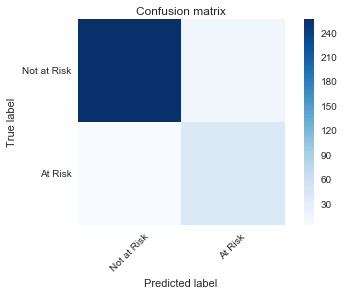

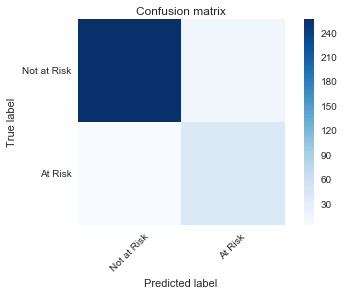

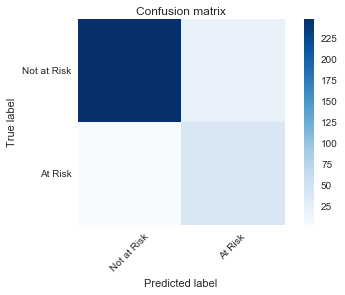

In [219]:
for n in range(1,4):
    print('n = ', n)
    pol_modeling.get_single_model(model=KNeighborsClassifier(n_neighbors=n), get_cm=True)
    print('\n')

#### Random Forest for important features

Avg Feature Importance: [ 0.11513645  0.1070692   0.12050754  0.17109364  0.13146482  0.15068214
  0.20404621]
Accuracy: 0.9606984126984126
Precision: 0.8750342391129682
Recall: 0.862127659574468
f1: 0.8670885787000947
ROC AUC: 0.9200563671006668


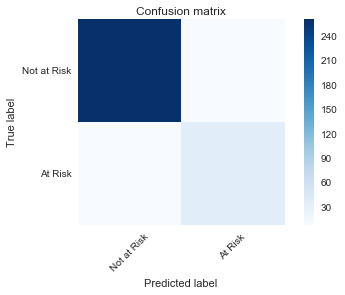

In [220]:
pol_modeling.get_single_model(model=RandomForestClassifier(n_estimators=100), get_cm = True)

Avg Feature Importance: [ 0.11748635  0.10621643  0.12166581  0.17026378  0.13094368  0.14984354
  0.2035804 ]
Accuracy: 0.9540317460317459
Precision: 0.8582743988470521
Recall: 0.8336170212765959
f1: 0.8433692987918517
ROC AUC: 0.9043831375039696


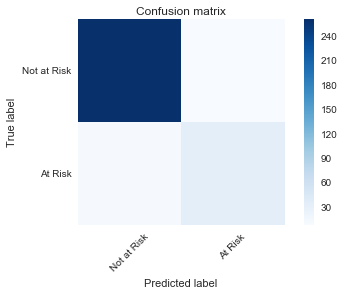

In [221]:
pol_modeling.get_single_model(model=RandomForestClassifier(n_estimators=30), get_cm = True)

#### DecisionTreeClassifier for important features

Avg Feature Importance: [ 0.09650796  0.1516766   0.10585536  0.20528953  0.14069824  0.11906713
  0.18090517]
Accuracy: 0.9346666666666665
Precision: 0.7945469089449493
Recall: 0.7646808510638299
f1: 0.7766598258545452
ROC AUC: 0.8645792315020642


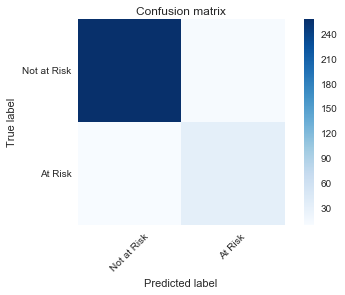

In [222]:
pol_modeling.get_single_model(model=DecisionTreeClassifier(), get_cm = True)

### Random forest, different number of trees

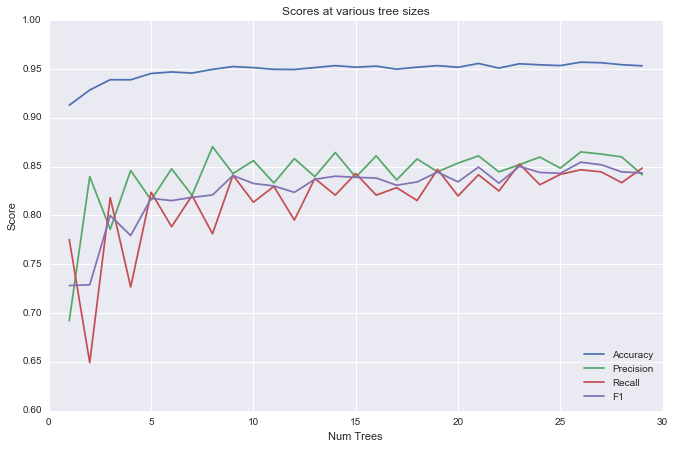

In [223]:
forest_acc = []
forest_prec = []
forest_rec = []
forest_f1 = []
forest_range = list(range(1,30))
for trees in forest_range:
    acc, prec, rec, f1, _ = pol_modeling.get_single_model(model=RandomForestClassifier(n_estimators=trees), verbose=False)
    forest_acc.append(acc)
    forest_prec.append(prec)
    forest_rec.append(rec)
    forest_f1.append(f1)

plt.figure(figsize=(11,7))
plt.plot(forest_range, forest_acc, label='Accuracy')
plt.plot(forest_range, forest_prec,label='Precision')
plt.plot(forest_range, forest_rec,label='Recall')
plt.plot(forest_range, forest_f1,label='F1')

plt.legend(loc='best')
plt.xlabel('Num Trees')
plt.ylabel('Score')
plt.title('Scores at various tree sizes')
plt.show()

    

## Testing for a single year

### With Oversampling

In [248]:
pol_modeling.get_multi_models(year=2013)

,Accuracy,Precision,Recall,F1,ROCAUC
KNeighborsClassifier(n_neighbors=2),0.922159,0.703786,0.820000,0.756677,0.879933
SVC(),0.926250,0.780182,0.696923,0.735438,0.831462
LogisticRegression(),0.689091,0.280560,0.700769,0.400143,0.693918
BernoulliNB(),0.471591,0.174713,0.576923,0.216957,0.515128
GaussianNB(),0.599659,0.227271,0.710000,0.343934,0.645267
RandomForestClassifier(n_estimators=30),0.909886,0.705019,0.671538,0.686546,0.811369
DecisionTreeClassifier(),0.894545,0.654201,0.610769,0.630266,0.777251


In [249]:
pol_modeling.get_multi_models(year=2012)

,Accuracy,Precision,Recall,F1,ROCAUC
KNeighborsClassifier(n_neighbors=2),0.954205,0.868776,0.841429,0.853757,0.908485
SVC(),0.959432,0.881391,0.862143,0.870669,0.919990
LogisticRegression(),0.656023,0.274195,0.702143,0.393689,0.674720
BernoulliNB(),0.309886,0.181243,0.819286,0.263147,0.516400
GaussianNB(),0.581591,0.230575,0.694286,0.345933,0.627278
RandomForestClassifier(n_estimators=30),0.954545,0.875650,0.835000,0.852941,0.906081
DecisionTreeClassifier(),0.936591,0.837646,0.747143,0.788027,0.859788


Avg Feature Importance: None
Accuracy: 0.9543181818181818
Precision: 0.8669302613630755
Recall: 0.8435714285714284
f1: 0.8542693873598907
ROC AUC: 0.9094208494208494


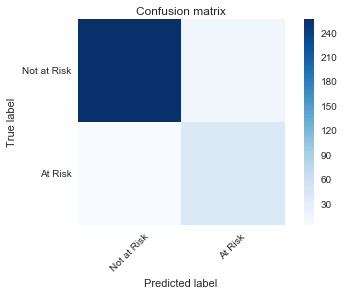

In [250]:
pol_modeling.get_single_model(year=2012, get_cm=True)

In [251]:
pol_modeling.get_multi_models(year=2011, year_delta=1)

,Accuracy,Precision,Recall,F1,ROCAUC
KNeighborsClassifier(n_neighbors=2),0.960462,0.903116,0.826154,0.862057,0.905186
SVC(),0.958960,0.859310,0.870769,0.864307,0.922664
LogisticRegression(),0.644740,0.251192,0.686154,0.367229,0.661784
BernoulliNB(),0.346590,0.163269,0.752308,0.232000,0.513569
GaussianNB(),0.591792,0.226058,0.705385,0.342156,0.638543
RandomForestClassifier(n_estimators=30),0.963584,0.920069,0.830000,0.872244,0.908605
DecisionTreeClassifier(),0.955145,0.892283,0.800000,0.842193,0.891293


In [252]:
pol_modeling.get_multi_models(year=2011, year_delta=2)

,Accuracy,Precision,Recall,F1,ROCAUC
KNeighborsClassifier(n_neighbors=2),0.936860,0.778296,0.766667,0.771868,0.865563
SVC(),0.935698,0.745118,0.820000,0.780358,0.887230
LogisticRegression(),0.671744,0.256709,0.710833,0.376871,0.688119
BernoulliNB(),0.501860,0.133214,0.505000,0.169000,0.503176
GaussianNB(),0.593372,0.224828,0.780000,0.348829,0.671554
RandomForestClassifier(n_estimators=30),0.935698,0.775066,0.760000,0.766705,0.862095
DecisionTreeClassifier(),0.935000,0.774449,0.754167,0.763558,0.859245


In [229]:
#full_data[full_data.zscores == 1]

In [239]:
pol_modeling.future_crisis_countries(year=2011, year_delta=1)

Empty DataFrame
Columns: [year_prior, prediction, prediction_actual, net]
Index: []
     year_prior  prediction  prediction_actual  net
HTI           0           1                  1   -1
     year_prior  prediction  prediction_actual  net
SYR           0           1                  1   -1
     year_prior  prediction  prediction_actual  net
SYR           0           1                  1   -1
     year_prior  prediction  prediction_actual  net
SSD           0           1                  1   -1
     year_prior  prediction  prediction_actual  net
HTI           0           1                  1   -1
SYR           0           1                  1   -1
     year_prior  prediction  prediction_actual  net
SSD           0           1                  1   -1
     year_prior  prediction  prediction_actual  net
SYR           0           1                  1   -1
     year_prior  prediction  prediction_actual  net
HTI           0           1                  1   -1
Empty DataFrame
Columns: [year_p